 ### GERMAN TRAFFIC SIGN RECOGNITION

Classification of trafficsigns on GTSRB dataset

In [ ]:
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras
from sklearn.utils import shuffle
import warnings
from tensorflow.keras import layers,models
from skimage import exposure
from keras.preprocessing.image import ImageDataGenerator
import pickle

matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


###ABOUT DATA

1.   We are using pickled data of GTSRB dataset which is already resized to 32x32 spatial dimensions
2.   The dataset contains training set and test set. Each are stored as dictionaries with images(size= [n,w,h,c]) are stored in the key name '*features*' and corresponding class id's as '*labels*' in a 1D array,where n=number of images,w=width,h=height,c=number of channels
3.we also downloaded the file 'signnames.csv' which associates the class id's to corresponding label names




#### LOADING AND SPLITTING THE DATA TO TRAINING AND VALIDATION SETS

In [ ]:
train_file='/content/drive/My Drive/seminar_auto/train.p'
test_file='/content/drive/My Drive/seminar_auto/test.p'
with open(train_file,mode='rb') as f:
  train_data=pickle.load(f)
with open(test_file,mode='rb') as f:
  test_data=pickle.load(f)
X=train_data['features']#stored the 4d image array to X
y=train_data['labels']#stored the corresponding labels of X to y
X_train_old, X_valid_old, y_train_old, y_valid_old= train_test_split(X, y, stratify=y, test_size=4000, random_state=0)
##split the training data to training and validation set 
print(X.shape[0])
print(y.shape[0])
'''
print("number of images in train set:",X_train.shape[0])
print("number of train_labels",y_train.shape[0])
print("number of images in validation set:",X_valid.shape[0])
print("number of valid_labels",y_valid.shape[0])
print("image shape:",X_train[0].shape)
'''
X_test, y_test = test_data['features'], test_data['labels'] #loading test set
print("number of images in test set:",X_test.shape[0])
print("number of test labels:",y_test.shape[0])
sign_classes, class_indices, class_counts = np.unique(y, return_index = True, return_counts = True)
num_classes=class_counts.shape[0]
print("number of classes:",num_classes)



39209
39209
number of images in test set: 12630
number of test labels: 12630
number of classes: 43


##DATA ANALYSIS

#####1)TO CHECK THE CLASS DISTRIBUTION IN THE TRAINING EXAMPLES
From the class distribution of training set it is clear that the data is unevenly distributed among the 43 classes. We need to balance this uneven distribution,so that we can train our model using more reliable training dataset. Inorder to do that we augment some of the images inside this data set and add this augmented images with their corresponding labels to our training dataset to make our training dataset sufficient for training

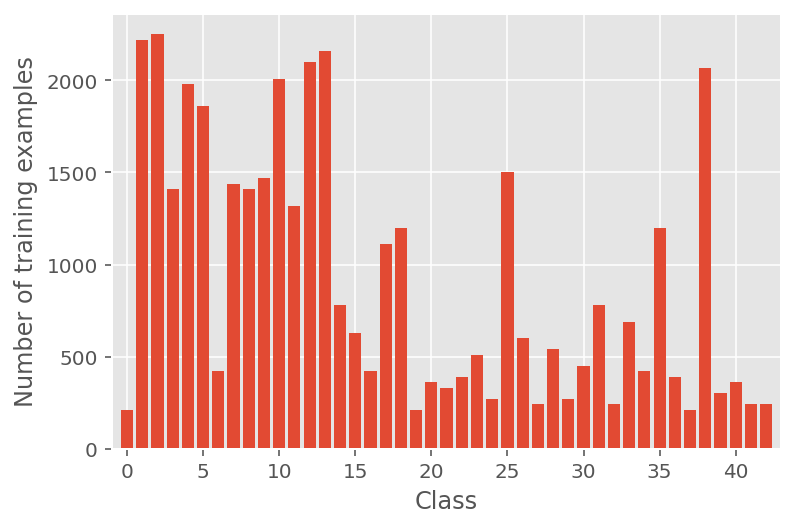

In [ ]:
plt.bar( np.arange( 43 ), class_counts, align='center' )
plt.xlabel('Class')
plt.ylabel('Number of training examples')
plt.xlim([-1, 43])
plt.show()

#####MAPPING SIGNNAMES TO CLASSID's AND SHOW RANDOM IMAGES WITH SIGN NAMES

Generating Random samples..


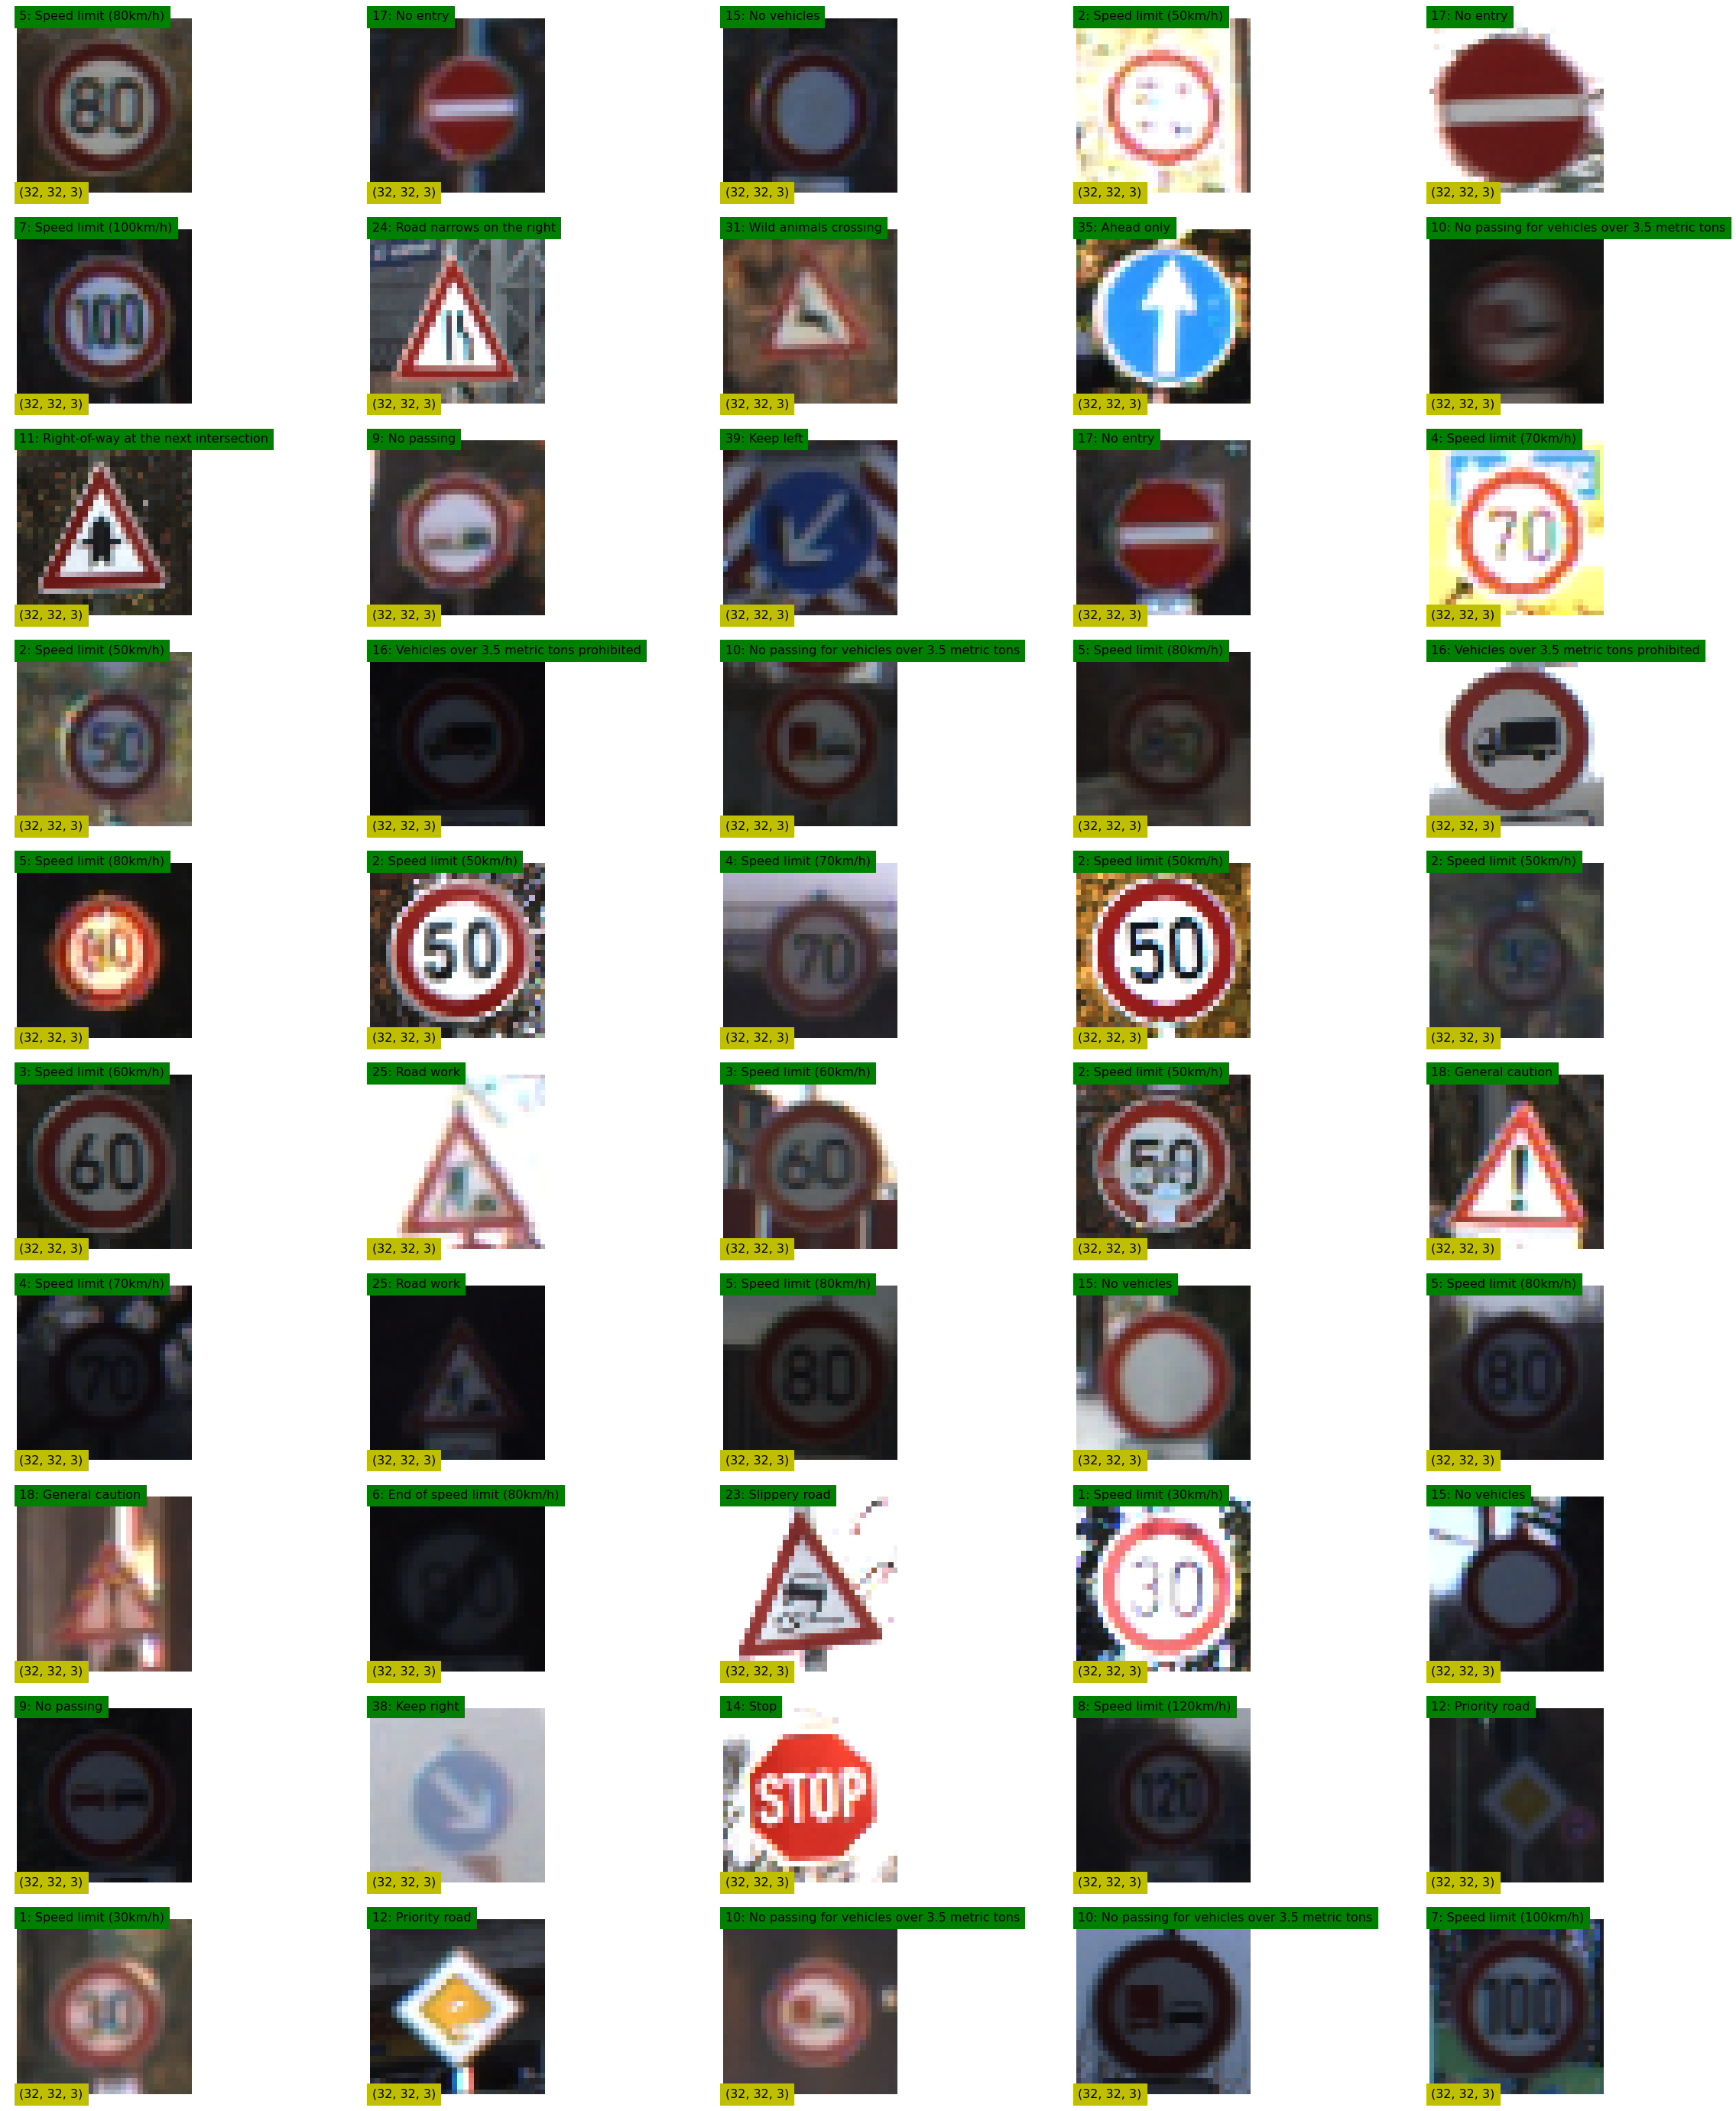

In [ ]:
sign_name_df = pd.read_csv('/content/drive/My Drive/seminar_auto/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId',inplace=True)
sign_name_df.head()

def get_name_from_label(label):
    # Helper, transofrm a numeric label into the corresponding string
    return sign_name_df.loc[label].SignName

sign_name_df['Occurence'] = [sum(y == c) for c in range(num_classes)]
sign_name_df.sort_values('Occurence', ascending=False)

def get_samples(num_samples, class_id=None):
    """
    Randomly select image filenames and their class IDs
    """
    if class_id is not None:
        if len(list(np.where(y==class_id))[0].tolist()) < num_samples:
            num_samples = len(list(np.where(y==class_id))[0].tolist())
        indices = random.sample(list(np.where(y==class_id))[0].tolist(), num_samples)
        return X[indices], y[indices]
    else:
        indices = np.random.choice(X.shape[0], size=num_samples, replace=False)
        return X[indices], y[indices]

def show_images(sample_x, sample_y, cols=5, sign_names=None, show_shape=False):
    """
    Given a list of images, load and show them.
    """
    
    num_images = len(sample_x)
    rows = num_images//cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4,rows*2.5))
    indexes = range(cols * rows)
    i = 1 
    for ax, index in zip(axes.flat, indexes):    
        image = sample_x[index]
        label = sample_y[index]
        if image.shape[2] == 1:
            ax.imshow(image.reshape(32,32), cmap='gray')
        else:
            ax.imshow(image)
                      
        if sign_names is not None:
            ax.text(0, 0, '{}: {}'.format(label, sign_names[label]), color='k',backgroundcolor='g', fontsize=8)        
        if show_shape:
            ax.text(0, image.shape[0], '{}'.format(image.shape), color='k',backgroundcolor='y', fontsize=8)        

        ax.set_xticks([], minor=False)
        ax.set_yticks([], minor=False)
        i += 1
sample_x, sample_y = get_samples(50)
print("Generating Random samples..")
show_images(sample_x, sample_y, sign_names=SIGN_NAMES, show_shape=True)

###DATA PREPROCESSING AND AUGMENTATION


In [ ]:
##DATA AUGMENTATION
def data_augment(image):
    rows= image.shape[0]
    cols = image.shape[1]
    
    # rotation
    M_rot = cv2.getRotationMatrix2D((cols/2,rows/2),20,1)
    
    # Translation
    M_trans = np.float32([[1,0,3],[0,1,6]])
    
    
    img = cv2.warpAffine(image,M_rot,(cols,rows))
    img = cv2.warpAffine(img,M_trans,(cols,rows))
  
    
 
    return img





In [ ]:

classes = 43

X_final = X
y_final = y
X_aug_1 = []
Y_aug_1 = []

for i in range(0,classes):
    
    class_records = np.where(y==i)[0].size
    max_records = 4000
    if class_records != max_records:
        ovr_sample = max_records - class_records
        samples = X[np.where(y==i)[0]]
        X_aug = []
        Y_aug = [i] * ovr_sample
        
        for x in range(ovr_sample):
            img = samples[x % class_records]
            trans_img = data_augment(img)
            X_aug.append(trans_img)
            
        X_final = np.concatenate((X_final, X_aug), axis=0)
        y_final = np.concatenate((y_final, Y_aug)) 
        #X_train=X_train_final
        #y_train=y_train_final
        
        Y_aug_1 = Y_aug_1 + Y_aug
        X_aug_1 = X_aug_1 + X_aug

[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42]
 [4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000
  4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000
  4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000 4000
  4000]]


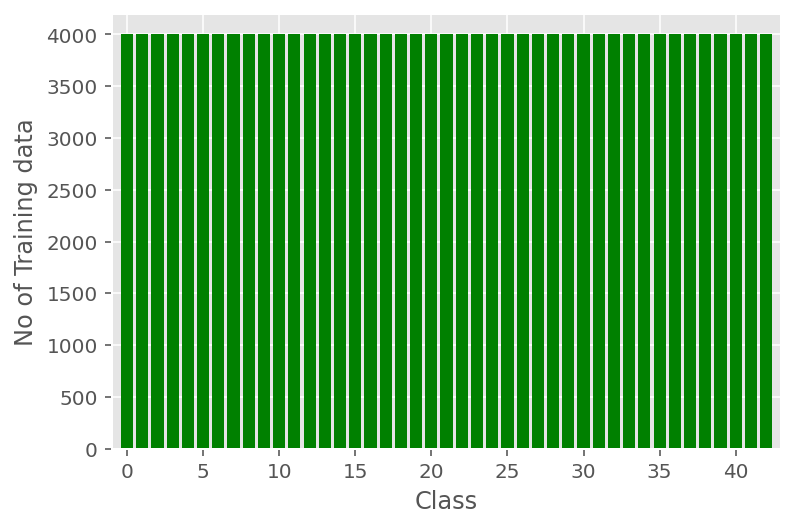

In [ ]:
unique_elements, counts_elements = np.unique(y_final, return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

plt.bar( np.arange( 43 ), counts_elements, align='center',color='green' )
plt.xlabel('Class')
plt.ylabel('No of Training data')
plt.xlim([-1, 43])

plt.show()

In [ ]:
#to check the number of samples after augmentation
print(len(X))
print(len(X_final))
print(len(y))
print(len(y_final))

X_train, X_valid, y_train, y_valid = train_test_split(X_final, y_final, stratify=y_final, test_size=34400, random_state=0)#spliting to training and validation using sklearn module
print("number of images in train set:",X_train.shape[0])
print("number of train_labels",y_train.shape[0])
print("number of images in validation set:",X_valid.shape[0])
print("number of valid_labels",y_valid.shape[0])
print("image shape:",X_train[0].shape)


39209
172000
39209
172000
number of images in train set: 137600
number of train_labels 137600
number of images in validation set: 34400
number of valid_labels 34400
image shape: (32, 32, 3)


In [ ]:
'''
sample_x, sample_y = get_samples(50)
print("Generating Random samples..")
show_images(sample_x, sample_y, sign_names=SIGN_NAMES, show_shape=True)
'''

'\nsample_x, sample_y = get_samples(50)\nprint("Generating Random samples..")\nshow_images(sample_x, sample_y, sign_names=SIGN_NAMES, show_shape=True)\n'

In [ ]:
#data preprocessing
def preprocess_dataset(X, y, one_hot=False):
    '''
    - convert images to grayscale, 
    - scale from [0, 255] to [0, 1] range, 
    - use localized histogram equalization as images differ 
      in brightness and contrast significantly
    ADAPTED FROM: http://navoshta.com/traffic-signs-classification/
    '''

    #Convert to grayscale, e.g. single channel Y
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]

    #Scale features to be in [0, 1]- Normalization
    X = (X / 255.).astype(np.float32)
    
    #adjust histogram
    for i in range(X.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X[i] = exposure.equalize_adapthist(X[i]) 
    
    if one_hot:
        # Convert to one-hot encoding. Convert back with `y = y.nonzero()[1]`
        y = np.eye(43)[y]
    
    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X, y

def makeDict(X, y):
    return {'features': X, 'labels': y}

def retriveDataFromDict(dictn):
    return dictn['features'], dictn['labels']

In [ ]:

training_preprocessed_file = "/content/drive/My Drive/seminar_auto/train_preprocessed.p"
validation_preprocessed_file = "/content/drive/My Drive/seminar_auto/valid_preprocessed.p"
testing_preprocessed_file = "/content/drive/My Drive/seminar_auto/test_preprocessed.p"

In [ ]:
## Please run this only first time and save the data into file
## so next time, we can directly load from file.

print("Preprocessing the data to improve feature extraction...")
print("This might take a while...")

X_train_preprocessed, y_train_preprocessed = preprocess_dataset(X_train, y_train)
print("training set preprocessing complete!", X_train_preprocessed.shape)

X_valid_preprocessed, y_valid_preprocessed = preprocess_dataset(X_valid, y_valid)
print("cross validation set preprocessing complete!", X_valid_preprocessed.shape)

X_test_preprocessed, y_test_preprocessed = preprocess_dataset(X_test, y_test)
print("test set preprocessing complete!", X_test_preprocessed.shape)

Preprocessing the data to improve feature extraction...
This might take a while...
training set preprocessing complete! (137600, 32, 32, 1)
cross validation set preprocessing complete! (34400, 32, 32, 1)
test set preprocessing complete! (12630, 32, 32, 1)


In [ ]:
# Save the preprocessed data set, so we don't have to preprocess it everytime 

pickle.dump(makeDict(X_train_preprocessed, y_train_preprocessed), open(training_preprocessed_file, "wb" ))
pickle.dump(makeDict(X_valid_preprocessed, y_valid_preprocessed), open(validation_preprocessed_file, "wb" ))
pickle.dump(makeDict(X_test_preprocessed, y_test_preprocessed), open(testing_preprocessed_file, "wb" ))

NameError: ignored

In [ ]:
with open(training_preprocessed_file, mode='rb') as f:
    X_train_preprocessed, y_train_preprocessed = retriveDataFromDict(pickle.load(f))
with open(validation_preprocessed_file, mode='rb') as f:
    X_valid_preprocessed, y_valid_preprocessed = retriveDataFromDict(pickle.load(f))
with open(testing_preprocessed_file, mode='rb') as f:
    X_test_preprocessed, y_test_preprocessed = retriveDataFromDict(pickle.load(f))

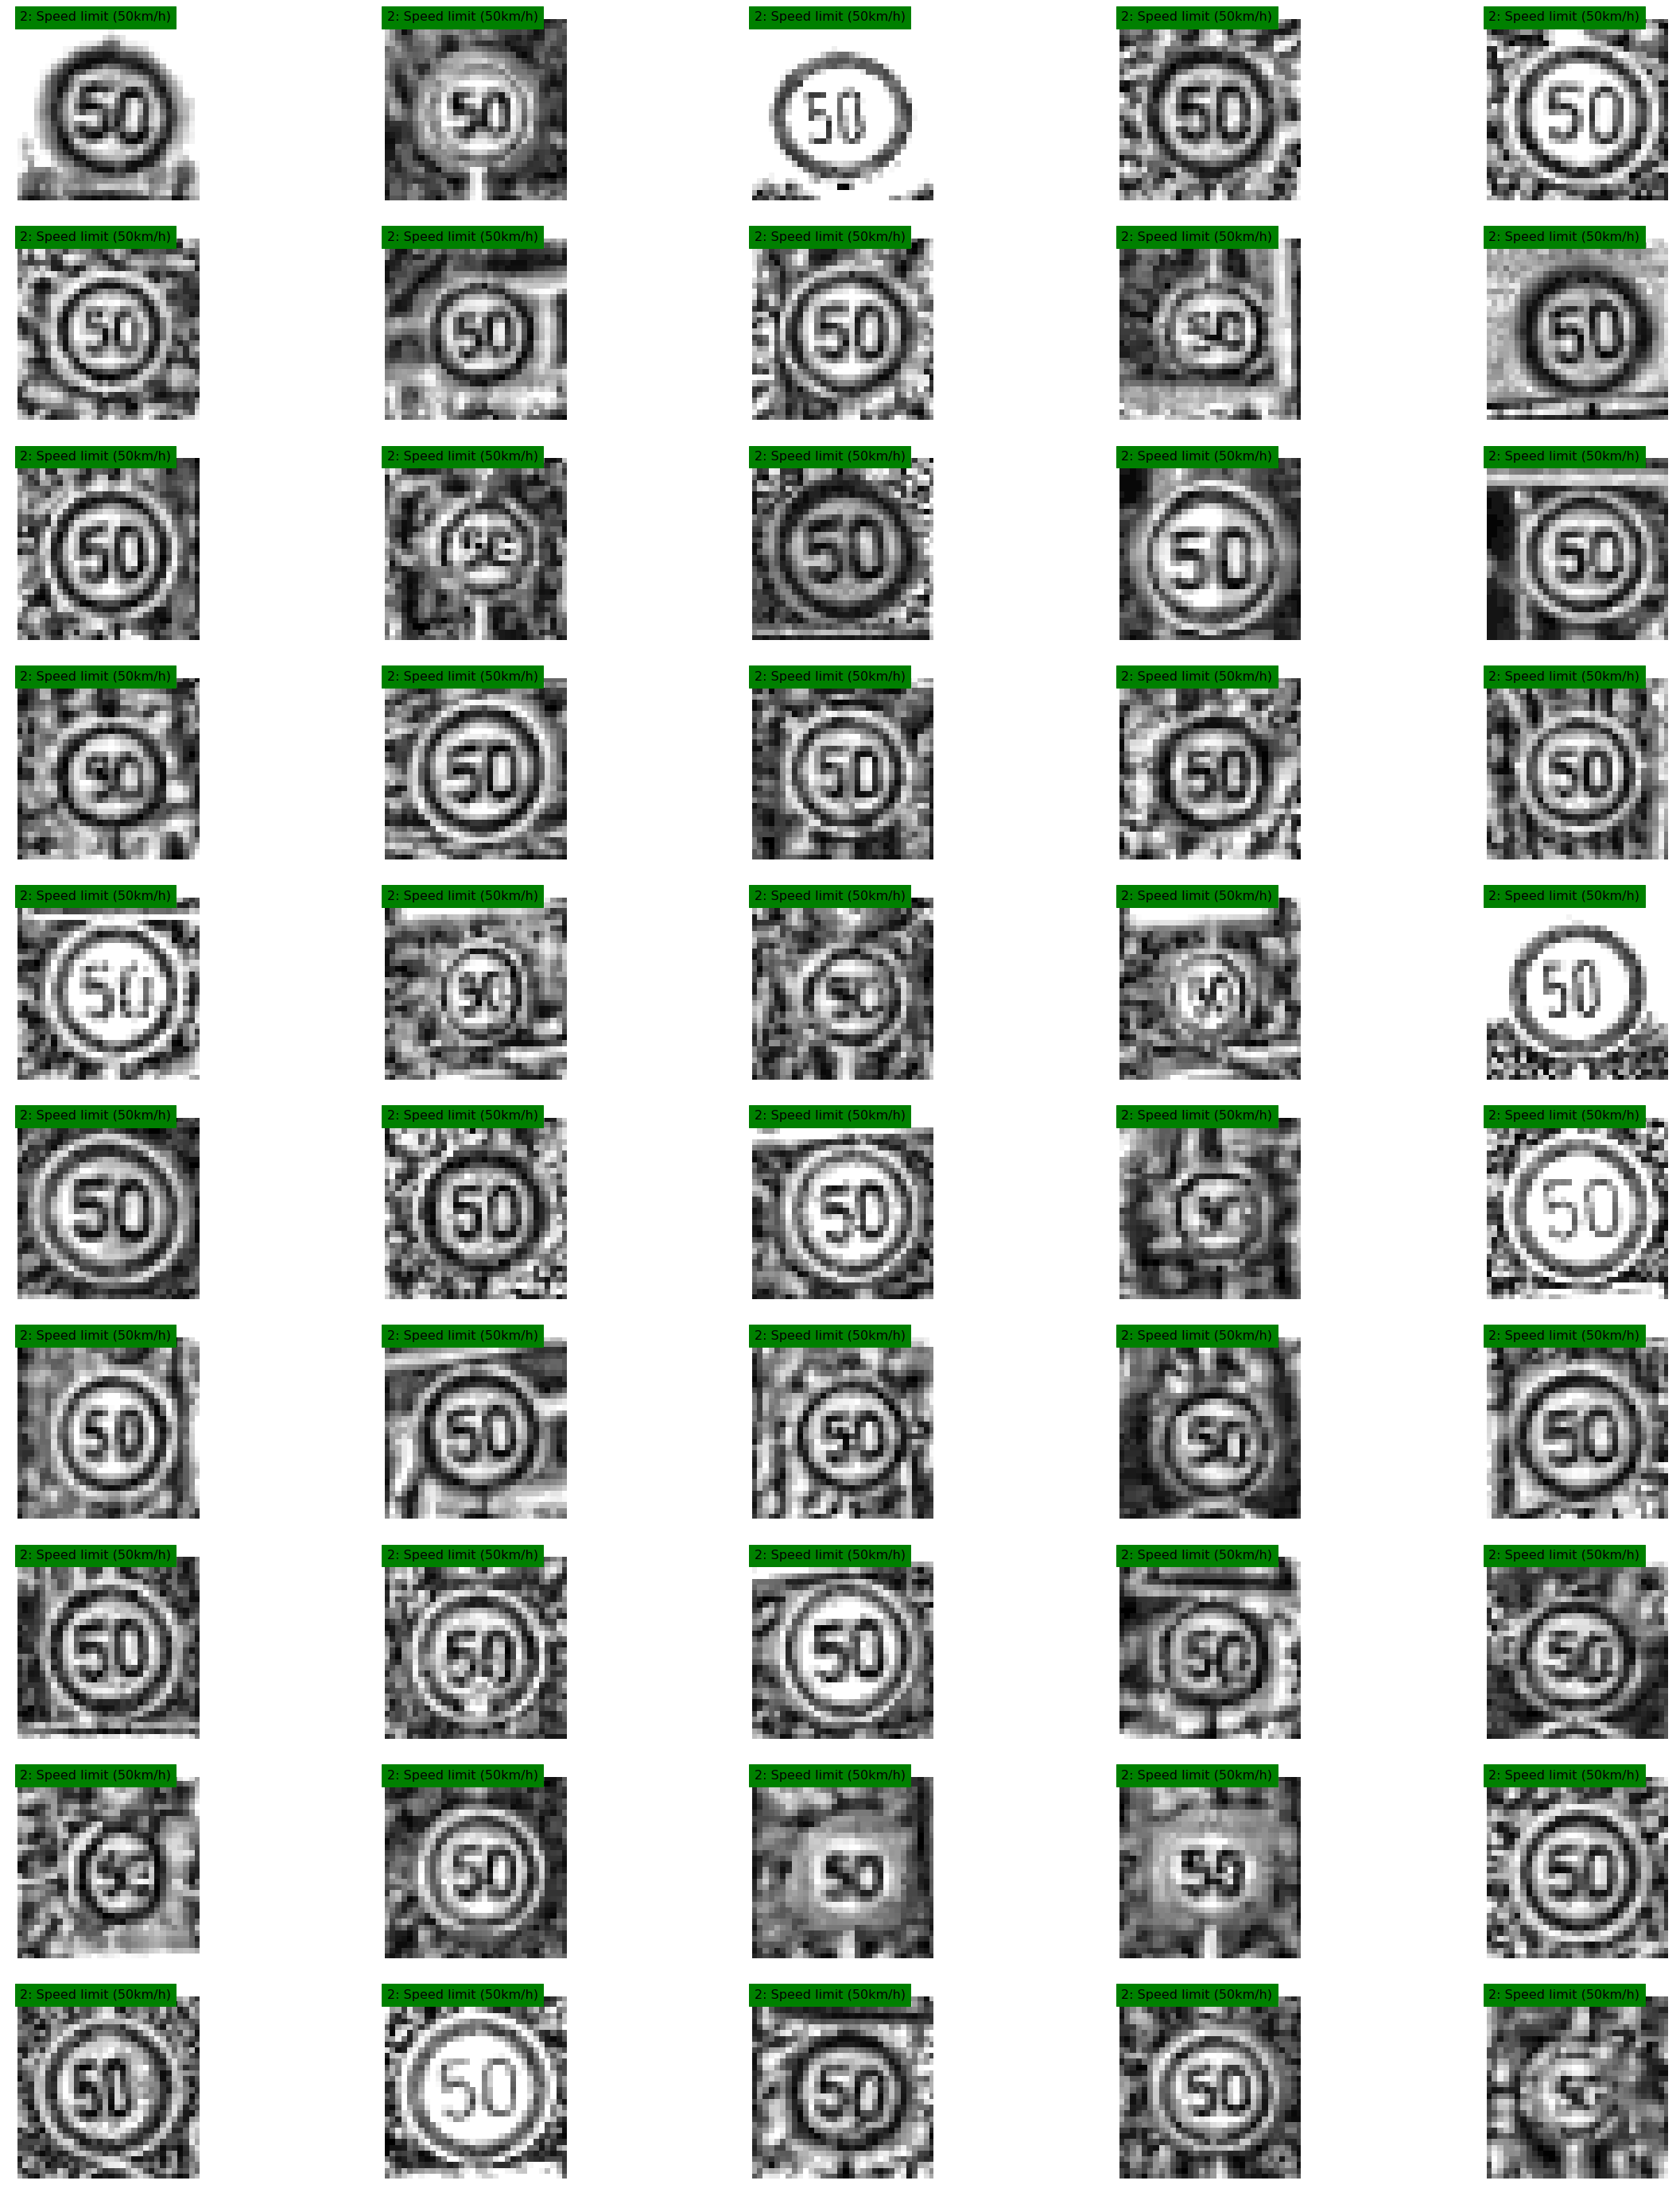

In [ ]:
sample_x_2, sample_y_2 = get_samples(num_samples=50, class_id=2)
sample_x_2_preprocessed, sample_y_2_preprocessed = preprocess_dataset(sample_x_2, sample_y_2, one_hot=False)
show_images(sample_x_2_preprocessed, sample_y_2_preprocessed, sign_names=SIGN_NAMES, show_shape=False)

###MODEL ARCHITECTURE


###MODEL ARCHITECTURE


In [ ]:
from tensorflow.keras import layers,models
def myModel():
  model=models.Sequential()
  model.add(layers.Conv2D(16,(3,3),activation='relu',input_shape=(32,32,1)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(32,(3,3),activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Dropout(0.1))
  model.add(layers.Conv2D(64,(3,3),activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Dropout(0.8))
  model.add(layers.Flatten())
  model.add(layers.Dense(120, activation='relu'))
  model.add(layers.Dropout(0.8))
  model.add(layers.Dense(84,activation='relu'))
  model.add(layers.Dropout(0.75))
  model.add(layers.Dense(43))
  opt=keras.optimizers.Adam(learning_rate=lr)
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

  



In [ ]:
#hyper_parameters
batch_size=64
epochs=15
lr=0.001


In [ ]:
model = myModel()
print(model.summary())
history=model.fit(X_train_preprocessed,y_train_preprocessed,batch_size,epochs,validation_data=(X_valid_preprocessed,y_valid_preprocessed),shuffle=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 16)        160       
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
batch_normalization_4 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 32)         

0.95043546


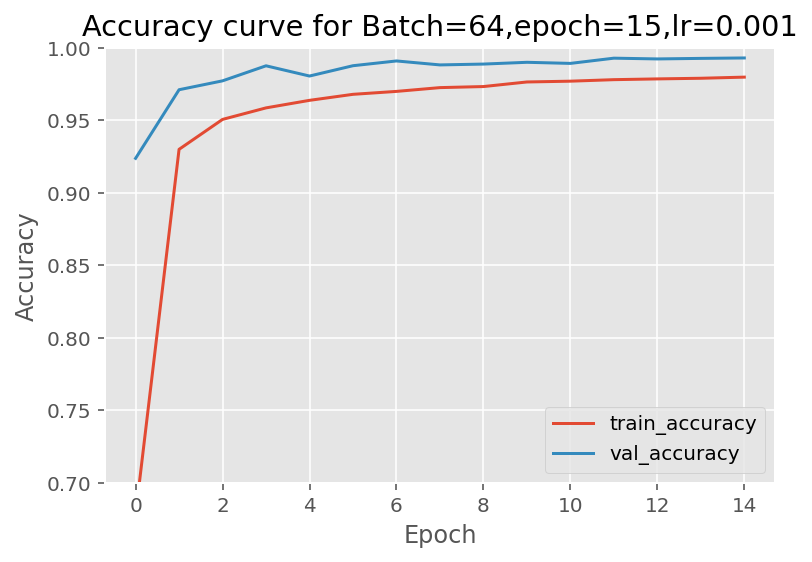

In [ ]:
#accuracy
plt.plot(history.history['acc'], label='train_accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='lower right')
plt.title('Accuracy curve for Batch=64,epoch=15,lr=0.001')






test_loss, test_acc = model.evaluate(X_test_preprocessed,  y_test_preprocessed, verbose=2)
print(test_acc)

Text(0.5, 1.0, 'loss curve for Batch=64,epoch=15,lr=0.001')

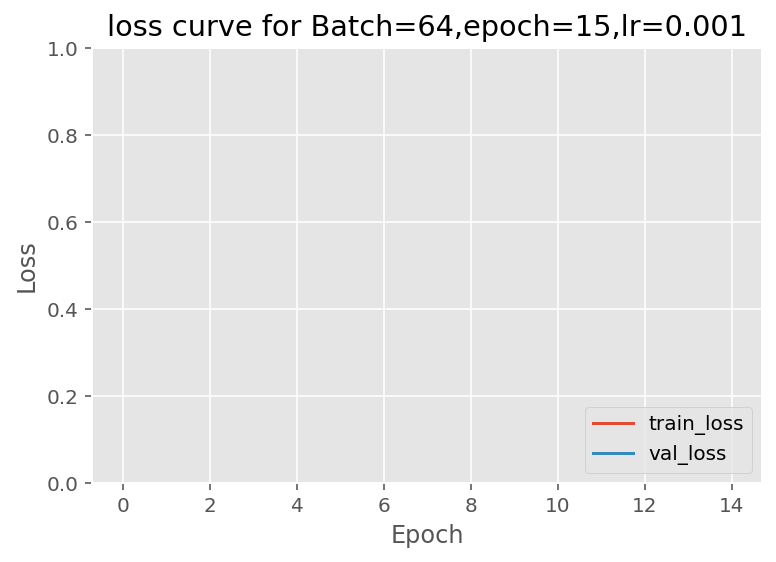

In [ ]:
#loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('loss curve for Batch=64,epoch=15,lr=0.001')